<a href="https://colab.research.google.com/github/arden333/CP2_hub/blob/main/funnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/CP2

/content/drive/MyDrive/Colab_Notebooks/CP2


In [4]:
# 그래프 테마 지정
sns.set_theme(style='white', palette='BrBG_r', font='D2coding')

#2.데이터 불러오기

In [ ]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 대용량 데이터 파일은 pyarrow 사용해서 불러옴
- 파일명에 new 있는 파일은 행 수는 동일, 컬럼이 세분화 → new 파일 사용

In [ ]:
# 대용량 파일 불러오기
import pyarrow.parquet as pq

clk = pq.read_pandas('./data/clk.parquet').to_pandas()
# cst = pd.read_csv('./data/cst.csv')
# prd = pd.read_csv('./data/prd.csv')
# trs = pd.read_csv('./data/trs.csv')

In [ ]:
clk['event_date'] = clk['event_time'].dt.strftime('%Y-%m-%d')
clk.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id,event_date
0,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0,2019-09-01
1,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,,,,NaN,18770.0,2019-09-01
2,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0,2019-09-01
3,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01 12:07:00.322763+00:00,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,,Dress Kondangan,,NaN,18770.0,2019-09-01
4,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:08:27.322763+00:00,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0,2019-09-01


#3. 데이터 분석

##3-1. 세션 최대 지속시간

- 모든 세션은 유일한 customer_id를 가지고 있음

In [ ]:
a = clk.groupby('session_id', as_index=False)['customer_id'].nunique()
a[a['customer_id']!=1]

In [ ]:
clk.head()

In [ ]:
clk.info()

In [ ]:
# 세션별 체류시간 구하기
start = clk.groupby('session_id')['event_time'].min()
end = clk.groupby('session_id')['event_time'].max()
time = end-start

In [ ]:
time.index

In [ ]:
user = clk.groupby('session_id', as_index=False)['customer_id'].count()

In [ ]:
ss_grp = clk.groupby('session_id', as_index=False)['event_time'].agg({'start':'min','end':'max'})
ss_grp['time'] = ss_grp['end'] - ss_grp['start']
ss_grp.head()


In [ ]:
ss_grp = ss_grp.merge(user, on='session_id')
ss_grp.rename(columns={'customer_id':'count'}, inplace=True)
ss_grp.head()

In [ ]:
ss_grp['time'].describe()

**세션의 일반적 의미**
- 홈페이지 방문자를 구분하기 위한 고유값으로 웹사이트에 접속한 후 떠난 시점까지를 의미함. 세션 타음아웃의 평균 시간은 30분
- A가 30분 내에 3번 접속하고 이탈해도 세션은 1로 기록

데이터 분석 결과
- 데이터를 보면 세션의 일반적 의미와 다른 듯. 각 고객이 고유의 session_id를 가지고 있고, 접속일자와 관계없이 계속 그 seesion_id가 유지됨
- 이벤트가 생길 때마다 세션이 생성되고 이벤트 개수 = 세션 수임
- <U>session_id가 아닌 유저별 event_name을 봐야 함</U>

- 유저당 평균 세션 수는 16개

In [ ]:
clk.groupby('customer_id', as_index=False)['session_id'].nunique().describe()

In [ ]:
print(clk.shape)
clk.head()

##3-2. 고객별 접속일수

In [ ]:
# 고객별 접속일수
visit_day = clk.groupby('customer_id', as_index=False)['event_date'].nunique()
visit_day.head()

In [ ]:
visit_day['event_date'].describe()

- 평균 접속일수는 86일(가입기간과 비교해봐야 함)

#4.퍼널분석

##4-1. 전처리

booking은 payment 성공 시 pay로 변경 
- 결제성공은 booking+pay인 이벤트. 위 처럼 할 경우 booking의 값이 왜곡되나 뒤에서 보완예정

In [ ]:
clk.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id,event_date
0,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0,2019-09-01
1,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,,,,NaN,18770.0,2019-09-01
2,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0,2019-09-01
3,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01 12:07:00.322763+00:00,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,,Dress Kondangan,,NaN,18770.0,2019-09-01
4,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:08:27.322763+00:00,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0,2019-09-01


In [ ]:
pay_s = clk[clk['event_name']=='BOOKING']
pay_s = pay_s[pay_s['payment_status']=='Success']
val = ['PAY' for i in range(len(pay_s))]
pay_s['event_name'] = val
print(pay_s.shape)
pay_s.head()

(815962, 13)


,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id
2,7d440441-e67a-4d36-b324-80ffd636d166,PAY,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0
19,f7b5cd60-4f87-4b3c-8bde-c7da8930eec2,PAY,2019-09-09 12:17:55.425431+00:00,3e6b12bf-2a80-4399-9afb-6bb1e0fa15bc,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0
38,b2843a94-248f-429e-bd54-1a456b4ef4a7,PAY,2019-09-17 12:17:58.425431+00:00,2d046ae1-7489-425f-95e3-926d87578c10,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0
45,d9aaa8a8-5e60-4e1e-ab0a-bb9755a7a3e9,PAY,2019-09-25 12:30:19.425431+00:00,622fb041-d094-43d7-988a-da0bb66f17f0,WEB,NaN,NaN,NaN,Success,,,NaN,18770.0
52,98e66f53-f24f-4238-8c9c-34a0482e22d5,PAY,2019-10-03 12:34:39.425431+00:00,8dcb9da3-a650-4649-b480-4ac8d97bb397,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0


In [ ]:
clk.iloc[pay_s.index] = pay_s
clk.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id
0,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0
1,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,,,,NaN,18770.0
2,7d440441-e67a-4d36-b324-80ffd636d166,PAY,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0
3,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01 12:07:00.322763+00:00,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,,Dress Kondangan,,NaN,18770.0
4,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:08:27.322763+00:00,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0


In [ ]:
# 퍼널 분석용 데이터프레임 생성
fnn = clk[['customer_id', 'event_name', 'event_date']]
fnn['event_date'] = pd.to_datetime(fnn['event_date'], format='%Y-%m-%d')
fnn['customer_id'] = fnn['customer_id'].astype('int')
fnn.head()

,customer_id,event_name,event_date
0,18770,HOMEPAGE,2019-09-01
1,18770,ADD_TO_CART,2019-09-01
2,18770,PAY,2019-09-01
3,18770,SEARCH,2019-09-01
4,18770,HOMEPAGE,2019-09-01


In [ ]:
f_dict = {'HOMEPAGE':0,
          'SEARCH':0,
          'SCROLL':0,
          'CLICK':0,
          'ITEM_DETAIL':1,
          'PROMO_PAGE':2,
          'ADD_PROMO':3,
          'ADD_TO_CART':4,
          'BOOKING':5,
          'PAY':6}
fnn['event_name'] = fnn['event_name'].apply(lambda x:f_dict[x])
fnn.head()

,customer_id,event_name,event_date
0,18770,0,2019-09-01
1,18770,4,2019-09-01
2,18770,6,2019-09-01
3,18770,0,2019-09-01
4,18770,0,2019-09-01


In [ ]:
print(fnn['event_date'].min())
print(fnn['event_date'].max())

2016-06-30 00:00:00
2022-08-01 00:00:00


In [ ]:
fnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12463004 entries, 0 to 12463003
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   customer_id  int64         
 1   event_name   int64         
 2   event_date   datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 285.3 MB


In [ ]:
type(fnn['event_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
# 2021년 1월~2022년 7월까지 기간에 대해서만 분석(최근 동향 파악)
start_date = pd.Timestamp('2021-01-01')
end_date = pd.Timestamp('2022-08-01')

fnn = fnn[(fnn['event_date'] >= start_date) & (fnn['event_date'] < end_date)]
print(fnn.shape)
fnn.head()

(6663883, 3)


,customer_id,event_name,event_date
1182,18770,6,2021-01-01
1199,18770,0,2021-01-01
1200,18770,0,2021-01-09
1201,18770,4,2021-01-09
1202,18770,5,2021-01-10


In [ ]:
# 메모리 부족할 경우 대비
fnn.to_csv('fnn.csv', index=False)
# fnn = pd.read_csv('./data/fnn.csv')
# fnn['event_date'] = pd.to_datetime(fnn['event_date'])
# fnn['event_date'] = fnn['event_date'].dt.strftime('%Y-%m')

In [ ]:
fnn.head()

,customer_id,event_name,event_date
0,18770,6,2021-01
1,18770,0,2021-01
2,18770,0,2021-01
3,18770,4,2021-01
4,18770,5,2021-01


##4-2. ~~사용자 기준 분석~~

세션의 타임아웃이 정해진 형태가 아니어서 특정 기간에 각 퍼널에 진입한 실 이용자수를 기준으로 퍼널을 분석함

In [ ]:
# 이용자 기준
funnel = fnn.groupby(['event_date', 'event_name'], as_index=False)['customer_id'].nunique()
funnel.columns = ['date', 'step', 'count']
funnel.set_index(['date', 'step'], inplace=True)
funnel.head()

count
date       step       
2021-01-01 0      2172
           1       569
           2       286
           3       221
           4       928

In [ ]:
# 연도별, 퍼널별 고객수
f = funnel['count'].unstack(1)
f.rename(columns={0:'visit',
                  1:'detail',
                  2:'promo_page',
                  3:'add_promo',
                  4:'add_to_cart',
                  5:'booking',
                  6:'pay'}, inplace=True)
f

step,visit,detail,promo_page,add_promo,add_to_cart,booking,pay
date,,,,,,,
2021-01,15482,8753,6078,5689,13863,753,12270
2021-02,14924,8418,5924,5451,13336,691,11754
2021-03,16017,9046,6349,5986,14399,762,12912
2021-04,16026,9052,6318,5943,14376,728,12790
2021-05,16312,9367,6638,6287,14739,827,13290
2021-06,16589,9447,6621,6195,15009,807,13282
2021-07,18091,10580,7284,6611,16501,915,14935
2021-08,18123,10642,7402,6747,16523,950,14995
2021-09,18416,10834,7573,6818,16816,920,15164


In [ ]:
try_booking = f['booking']+f['pay'] 
f.insert(5, 'try_booking', try_booking)
f.drop('booking', axis=1, inplace=True)
f

step,visit,detail,promo_page,add_promo,add_to_cart,try_booking,pay
date,,,,,,,
2021-01,15482,8753,6078,5689,13863,13023,12270
2021-02,14924,8418,5924,5451,13336,12445,11754
2021-03,16017,9046,6349,5986,14399,13674,12912
2021-04,16026,9052,6318,5943,14376,13518,12790
2021-05,16312,9367,6638,6287,14739,14117,13290
2021-06,16589,9447,6621,6195,15009,14089,13282
2021-07,18091,10580,7284,6611,16501,15850,14935
2021-08,18123,10642,7402,6747,16523,15945,14995
2021-09,18416,10834,7573,6818,16816,16084,15164


In [ ]:
a = f[['visit','detail','add_to_cart','try_booking','pay']]
a
a['visit-cart'] = round(a['add_to_cart']/a['visit'],2)
a['cart-book'] = round(a['try_booking']/a['add_to_cart'],2)
a['book-pay'] = round(a['pay']/a['try_booking'],2)
a


step,visit,detail,add_to_cart,try_booking,pay,visit-cart,cart-book,book-pay
date,,,,,,,,
2021-01,15482,8753,13863,13023,12270,0.90,0.94,0.94
2021-02,14924,8418,13336,12445,11754,0.89,0.93,0.94
2021-03,16017,9046,14399,13674,12912,0.90,0.95,0.94
2021-04,16026,9052,14376,13518,12790,0.90,0.94,0.95
2021-05,16312,9367,14739,14117,13290,0.90,0.96,0.94
2021-06,16589,9447,15009,14089,13282,0.90,0.94,0.94
2021-07,18091,10580,16501,15850,14935,0.91,0.96,0.94
2021-08,18123,10642,16523,15945,14995,0.91,0.97,0.94
2021-09,18416,10834,16816,16084,15164,0.91,0.96,0.94


- detail 없이 add_to_cart 하는 경우가 많음
- 전환율이 너무 높게 나옴
- 순차적으로 퍼널을 통과하며 구매하는 경우가 있고 아닌 경우가 있는데, 모두 합산 카운팅되어서 그런 듯
- 구매패턴의 분포를 보고 퍼널을 순차적으로 통과한 데이터에 한해서 재분석 필요


-----

##4-3. 각 구매건수 기준 분석(구매패턴 기반)

In [ ]:
fnn = pd.read_csv('./data/fnn.csv')
fnn['event_date'] = pd.to_datetime(fnn['event_date'])
fnn['event_date'] = fnn['event_date'].dt.strftime('%Y-%m')

In [ ]:
fnn.head()

,customer_id,event_name,event_date
0,18770,6,2021-01
1,18770,0,2021-01
2,18770,0,2021-01
3,18770,4,2021-01
4,18770,5,2021-01


In [ ]:
fnn = fnn.groupby(['customer_id','event_date']).agg({'event_name':'unique'})
fnn = fnn.reset_index()
fnn

,customer_id,event_date,event_name
0,3,2021-01,"[0, 4, 3, 6, 1, 2]"
1,3,2021-02,"[0, 4, 6]"
2,3,2021-03,"[0, 4, 6, 1, 3, 2]"
3,3,2021-04,"[6, 0, 4, 3, 2, 1]"
4,3,2021-05,"[6, 0, 4, 1]"
...,...,...,...
368892,99995,2022-07,"[0, 4, 6, 2, 1]"
368893,99998,2021-01,"[0, 4, 3, 6, 1]"
368894,99998,2021-07,"[0, 4, 6, 1]"
368895,99998,2021-12,"[0, 4, 1]"


###4-3-1. 퍼널 유형 파악 및 기준 설정

In [ ]:
event = fnn[['event_name']]
event.rename(columns={'event_name':'step'}, inplace=True)
event

,step
0,"[0, 4, 3, 6, 1, 2]"
1,"[0, 4, 6]"
2,"[0, 4, 6, 1, 3, 2]"
3,"[6, 0, 4, 3, 2, 1]"
4,"[6, 0, 4, 1]"
...,...
368892,"[0, 4, 6, 2, 1]"
368893,"[0, 4, 3, 6, 1]"
368894,"[0, 4, 6, 1]"
368895,"[0, 4, 1]"


In [ ]:
type(event.step[0])

numpy.ndarray

In [ ]:
# ndarray를 리스트로 변환
event.step = event.step.apply(lambda x:list(x))

In [9]:
# step의 value_counts() 위해 데이터 변환 함수 정의
def process(x):
    if 6 in x: # 6(pay) 포함 시 5(booking) 추가
        x.append(5)
    x.sort()
    x = ''.join([str(n) for n in x])
    return x

- 전처리 과정에서 결제성공한 event를 pay로 치환하는 과정에서 booking이 왜곡됨
- pay = booking+결제성공 이므로 booking의 과정을 추가해줌

In [ ]:
event.step = event.step.apply(lambda x:process(x))

In [ ]:
event['step_count'] = event.step.apply(lambda x:len(x))
event.head()

,step,step_count
0,0123456,7
1,0456,4
2,0123456,7
3,0123456,7
4,01456,5


In [ ]:
# 평균 4단계의 퍼널을 거친다
event['step_count'].describe()

count    368897.000000
mean          4.578251
std           1.828878
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max           8.000000
Name: step_count, dtype: float64

In [ ]:
print(f'퍼널 종류 : {event.step.nunique()}')
event.step.value_counts()

퍼널 종류 : 100


0123456    55045
0456       40497
01456      40472
012456     38783
56         25780
           ...  
0235           4
1345           4
2345           2
125            1
235            1
Name: step, Length: 100, dtype: int64

In [ ]:
print(event.shape)
event.head()

(368897, 2)


,step,step_count
0,0123456,7
1,0456,4
2,0123456,7
3,0123456,7
4,01456,5


In [ ]:
# 퍼널이 4개(평균치) 이상인 경우 : 72%
a = event.query('step_count>=4')['step'].count()
round(a/event.shape[0],2)

0.72

In [ ]:
# 0만 있는 경우와 1이 포함된 경우
a = event[(event.step=='0') | (event.step.str.contains('1'))]
round(a.shape[0]/event.shape[0],2)                                              

0.58

- 중요 event는 1,4,5,6으로 설정
- 따라서, 0과 1이 포함되지 않은 경우(탐색을 거치지 않는 경우는 제외
- 0 → 4가 가능한 것으로 볼 때 상세페이지를 거치지 않고도 구매는 가능한 것으로 예상되나, 분석 기준에서는 반드시 상세페이지를 거친 후 카트담기, 결제가 가능한 것으로 전제

In [ ]:
a.describe()

,step_count
count,214922.000000
mean,5.391779
std,1.707117
min,1.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,8.000000


In [ ]:
event.step.value_counts().head(10)

0123456    55045
0456       40497
01456      40472
012456     38783
56         25780
04         20677
013456     20548
0          14219
03456      13876
014        10133
Name: step, dtype: int64

In [ ]:
# top10 = event.step.value_counts(normalize=True).head(10).sum()
# top5 = event.step.value_counts(normalize=True).head(5).sum()
# print(f'상위 10개 유형 비중 : {top10*100:.2f}%')
# print(f'상위 5개 유형 비중 : {top5*100:.2f}%')

###4-3-2. 전환율 계산

- 동일한 이용자라도 구매형태가 다름
- 이용자 기준 아닌 주문건수 기준으로 계산


In [ ]:
funnel = fnn.copy()
funnel.columns = ['customer_id', 'date', 'step']
funnel.head()

,customer_id,date,step
0,3,2021-01,"[0, 4, 3, 6, 1, 2]"
1,3,2021-02,"[0, 4, 6]"
2,3,2021-03,"[0, 4, 6, 1, 3, 2]"
3,3,2021-04,"[6, 0, 4, 3, 2, 1]"
4,3,2021-05,"[6, 0, 4, 1]"


In [ ]:
# ndarray를 리스트로 변환
funnel.step = funnel.step.apply(lambda x:list(x))
# step에 함수 적용
funnel.step = funnel.step.apply(lambda x:process(x))
print(funnel.shape)
funnel.head()

(368897, 3)


,customer_id,date,step
0,3,2021-01,0123456
1,3,2021-02,0456
2,3,2021-03,0123456
3,3,2021-04,0123456
4,3,2021-05,01456


In [ ]:
f = funnel.groupby(['date','step'], as_index=False)['customer_id'].count()
f.rename(columns={'customer_id':'count'}, inplace=True)
f.sample(10)

,date,step,count
1378,2022-04,156,55
780,2021-09,34,11
1242,2022-03,0134556,56
649,2021-08,0245,15
1443,2022-05,035,1
124,2021-02,0234556,10
577,2021-07,056,399
1572,2022-07,0235,1
1038,2021-12,2356,2
1240,2022-03,0134,244


In [ ]:
f['count'].sum() == funnel.shape[0]

True

In [ ]:
# step1. 탐색 - 검색, 클릭, 스크롤 등
s1 = f[f['step'].str.contains('0')|f['step'].str.contains('1')].groupby('date', as_index=False)['count'].sum()
s1.columns = ['date','visit']
print(s1['visit'].sum())
s1.head()

334742


,date,visit
0,2021-01,15727
1,2021-02,15146
2,2021-03,16215
3,2021-04,16251
4,2021-05,16546


In [ ]:
# step2. 관심 - 상세페이지
# 0 → 1로 전환
s2 = f[f['step'].str.contains('01')].groupby('date', as_index=False)['count'].sum()
s2.columns = ['date','interest']
print(s2['interest'].sum())
s2.head()

197154


,date,interest
0,2021-01,8508
1,2021-02,8196
2,2021-03,8848
3,2021-04,8827
4,2021-05,9133


In [ ]:
# step3. 구매의사 - add to cart, booking
# (0,1,4) 또는 (0,1,5) 또는 (0,1,4,5)  포함
s3 = f[f['step'].str.contains('014') | 
         f['step'].str.contains('015') |
         f['step'].str.contains('0145')].groupby('date', as_index=False)['count'].sum()
s3.columns = ['date','purchase_intent']
print(s3['purchase_intent'].sum())
s3.head()

56283


,date,purchase_intent
0,2021-01,2532
1,2021-02,2389
2,2021-03,2660
3,2021-04,2556
4,2021-05,2592


In [ ]:
# step4. 결제 완료 - apy
# (0,1,4,6) 또는 (0,1,5,6) 또는 (0,1,4,5,6)  포함
s4 = f[f['step'].str.contains('0146') | 
             f['step'].str.contains('0156') |
             f['step'].str.contains('01456')].groupby('date', as_index=False)['count'].sum()
s4.columns = ['date','purchase']
print(s4['purchase'].sum())
s4.head()

43625


,date,purchase
0,2021-01,1888
1,2021-02,1729
2,2021-03,1996
3,2021-04,1871
4,2021-05,1907


In [ ]:
cv = pd.merge(s1, s2, on='date')
cv = pd.merge(cv, s3, on='date')
cv = pd.merge(cv, s4, on='date')
cv.head()

,date,visit,interest,purchase_intent,purchase
0,2021-01,15727,8508,2532,1888
1,2021-02,15146,8196,2389,1729
2,2021-03,16215,8848,2660,1996
3,2021-04,16251,8827,2556,1871
4,2021-05,16546,9133,2592,1907


In [ ]:
cv['to_interest'] = round(cv['interest'] / cv['visit'],2)
cv['to_intent'] = round(cv['purchase_intent'] / cv['interest'],2)
cv['to_purchase'] = round(cv['purchase'] / cv['purchase_intent'],2)
cv

,date,visit,interest,purchase_intent,purchase,to_interest,to_intent,to_purchase
0,2021-01,15727,8508,2532,1888,0.54,0.30,0.75
1,2021-02,15146,8196,2389,1729,0.54,0.29,0.72
2,2021-03,16215,8848,2660,1996,0.55,0.30,0.75
3,2021-04,16251,8827,2556,1871,0.54,0.29,0.73
4,2021-05,16546,9133,2592,1907,0.55,0.28,0.74
5,2021-06,16833,9203,2711,2021,0.55,0.29,0.75
6,2021-07,18311,10360,3140,2388,0.57,0.30,0.76
7,2021-08,18335,10430,3098,2350,0.57,0.30,0.76
8,2021-09,18629,10621,3130,2382,0.57,0.29,0.76
9,2021-10,19336,11061,3248,2444,0.57,0.29,0.75


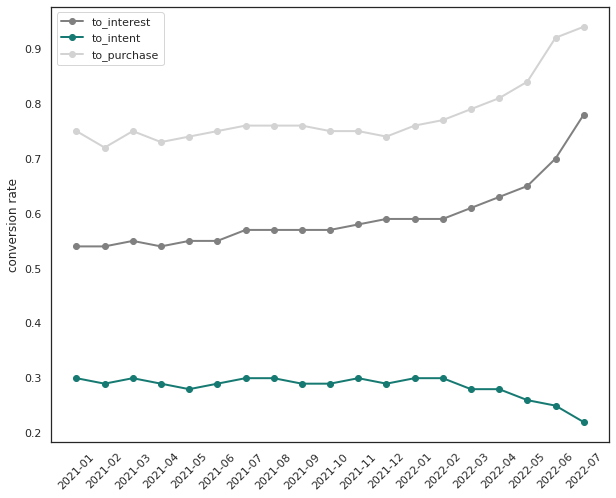

In [ ]:
# 시각화
cv_g = cv[['date', 'to_interest', 'to_intent', 'to_purchase']]
cv_g.set_index('date', inplace=True)
labels = cv_g.columns

plt.figure(figsize=(10,8))
# for l in labels:
#     x = cv_g.index
#     y = cv_g[l]
#     sns.pointplot(x=x, y=y, label=l)
#     plt.legend()
plt.plot(cv_g.index, cv_g['to_interest'], label='to_interest', linewidth=2, color='gray', marker='o')
plt.plot(cv_g.index, cv_g['to_intent'], label='to_intent', linewidth=2, marker='o')
plt.plot(cv_g.index, cv_g['to_purchase'], label='to_purchase', linewidth=2, color='lightgray', marker='o')

plt.legend(labels) #loc='upper left', bbox_to_anchor=(1,1)
plt.ylabel('conversion rate')
plt.xticks(rotation=45)
plt.show();

- 상세페이지에서 카트담기 또는 결제까지의 전환율이 30% 미만으로 낮으며, 갈수록 낮아지고 있음

###4-3-3. 전환율 높은 그룹 찾기 - 보류

- 상세페이지 → 카트담기  또는 결제까지 전환율이 높은 그룹과 아닌 그룹의 특징 찾아보자
- 추천시스템으로 가는 결론의 근거 찾아보기

In [ ]:
data = clk[['customer_id','event_time','event_name','traffic_source','product_id','search_keywords']]
data['product_id'].fillna(0, inplace=True)
data = data.astype({'customer_id':'int', 'product_id':'int'})
data['event_time'] = pd.to_datetime(data['event_time'])
data['event_time'] = data['event_time'].dt.strftime('%Y-%m')
f_dict = {'HOMEPAGE':0,
          'SEARCH':0,
          'SCROLL':0,
          'CLICK':0,
          'ITEM_DETAIL':1,
          'PROMO_PAGE':2,
          'ADD_PROMO':3,
          'ADD_TO_CART':4,
          'BOOKING':5,
          'PAY':6}
data['event_name'] = data['event_name'].apply(lambda x:f_dict[x])
data.head()

,customer_id,event_time,event_name,traffic_source,product_id,search_keywords
0,18770,2019-09,0,MOBILE,0,
1,18770,2019-09,4,MOBILE,15315,
2,18770,2019-09,5,MOBILE,0,
3,18770,2019-09,0,MOBILE,0,Dress Kondangan
4,18770,2019-09,0,MOBILE,0,


In [ ]:
# 2021년 1월~2022년 7월까지 기간에 대해서만 분석(최근 동향 파악)
start_date = '2021-01'
end_date = '2022-08'

data = data[(data['event_time'] >= start_date) & (data['event_time'] < end_date)]

print(data.shape)
data.head()

(6663883, 6)


,customer_id,event_time,event_name,traffic_source,product_id,search_keywords
1182,18770,2021-01,5,MOBILE,0,
1199,18770,2021-01,0,MOBILE,0,
1200,18770,2021-01,0,MOBILE,0,
1201,18770,2021-01,4,MOBILE,13072,
1202,18770,2021-01,5,MOBILE,0,


In [ ]:
data['traffic_source'].value_counts()

MOBILE    5998249
WEB        665634
Name: traffic_source, dtype: int64

In [ ]:
data['traffic_source'] = data['traffic_source'].replace({'MOBILE':1, 'WEB':0})
a = data.groupby(['customer_id','event_time'], as_index=False).agg({'event_name':'unique', 'traffic_source':'mean', 'product_id':'unique'})
a.rename(columns={'event_time':'date', 'product_id':'cart_product'},  inplace=True)
a.head()

,customer_id,date,event_name,traffic_source,cart_product
0,3,2021-01,"[0, 4, 3, 5, 1, 2]",1.0,"[0, 3108, 45409, 56913, 19313, 22491]"
1,3,2021-02,"[0, 4, 5]",1.0,"[0, 55876]"
2,3,2021-03,"[0, 4, 5, 1, 3, 2]",1.0,"[0, 29069, 23582, 48580, 18896, 16740]"
3,3,2021-04,"[5, 0, 4, 3, 2, 1]",1.0,"[0, 54551, 12473, 24260, 19029, 11896, 21552, ..."
4,3,2021-05,"[5, 0, 4, 1]",1.0,"[0, 40091, 9166]"


In [ ]:
trs = pd.read_csv('./data/trs.csv')
trs.head()

,created_at,customer_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,total_amount,product_id,quantity
0,2018-07-29T15:22:01.458193Z,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,189832,54728,1
1,2018-07-30T12:40:22.365620Z,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,145526,16193,1
2,2018-09-15T11:51:17.365620Z,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,540696,53686,4
3,2018-11-01T11:23:48.365620Z,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,271012,20228,1
4,2018-12-18T11:20:30.365620Z,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,198753,55220,1


data(from clk)상 booking, pay의 product_id를 trs의 product_id를 매칭

In [ ]:
trs = trs[['created_at','customer_id','payment_status','product_id']]
trs.rename(columns={'created_at':'date'}, inplace=True)
trs['date'] = pd.to_datetime(trs['date'])
trs['date'] = trs['date'].dt.strftime('%Y-%m')

# 2021년 1월~2022년 7월까지 기간에 대해서만 분석(최근 동향 파악)
start_date = '2021-01'
end_date = '2022-08'
prd_info = trs[(trs['date'] >= start_date) & (trs['date'] < end_date)]

# payment_status를 booking과 pay로 바꿈
prd_info['payment_status'] = prd_info['payment_status'].replace({'Success':6, 'Failed':5})
prd_info.rename(columns={'payment_status':'event_name'}, inplace=True)
prd_info.head()

,date,customer_id,event_name,product_id
31,2021-01,4774,6,31302
32,2021-02,4774,6,11599
33,2021-04,4774,6,39204
34,2021-05,4774,6,6572
35,2021-07,4774,6,18001


In [ ]:
a.head()

,customer_id,date,event_name,traffic_source,cart_product
0,3,2021-01,"[0, 4, 3, 5, 1, 2]",1.0,"[0, 3108, 45409, 56913, 19313, 22491]"
1,3,2021-02,"[0, 4, 5]",1.0,"[0, 55876]"
2,3,2021-03,"[0, 4, 5, 1, 3, 2]",1.0,"[0, 29069, 23582, 48580, 18896, 16740]"
3,3,2021-04,"[5, 0, 4, 3, 2, 1]",1.0,"[0, 54551, 12473, 24260, 19029, 11896, 21552, ..."
4,3,2021-05,"[5, 0, 4, 1]",1.0,"[0, 40091, 9166]"


In [ ]:
b = prd_info.groupby(['customer_id','date'], as_index=False).agg({'event_name':'unique', 'product_id':'unique'})
b.rename(columns={'product_id':'pay_product'}, inplace=True)
b.head()

,customer_id,date,event_name,pay_product
0,3,2021-01,[6],[3108]
1,3,2021-02,[6],[55876]
2,3,2021-03,[6],"[29069, 23582]"
3,3,2021-04,[6],[48580]
4,3,2021-05,[6],"[54551, 12473, 40091, 9166]"


In [ ]:
print(a.shape)
print(b.shape)

(368897, 5)
(292312, 4)


In [ ]:
cv = pd.merge(a, b, how='left', on=['customer_id','date'])
cv.dropna(inplace=True)
cv.head()

,customer_id,date,event_name_x,traffic_source,cart_product,event_name_y,pay_product
0,3,2021-01,"[0, 4, 3, 5, 1, 2]",1.0,"[0, 3108, 45409, 56913, 19313, 22491]",[6],[3108]
1,3,2021-02,"[0, 4, 5]",1.0,"[0, 55876]",[6],[55876]
2,3,2021-03,"[0, 4, 5, 1, 3, 2]",1.0,"[0, 29069, 23582, 48580, 18896, 16740]",[6],"[29069, 23582]"
3,3,2021-04,"[5, 0, 4, 3, 2, 1]",1.0,"[0, 54551, 12473, 24260, 19029, 11896, 21552, ...",[6],[48580]
4,3,2021-05,"[5, 0, 4, 1]",1.0,"[0, 40091, 9166]",[6],"[54551, 12473, 40091, 9166]"


In [ ]:
# ndarray를 리스트로 변환
cols = ['event_name_x', 'event_name_y', 'cart_product', 'pay_product']
for c in cols:
    cv[c] = cv[c].apply(lambda x:list(x))

In [ ]:
cv['product'] = cv['cart_product'] + cv['pay_product']
cv.head()

### 새로운 접근 시도

In [ ]:
clk.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,customer_id
0,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0
1,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,,,,NaN,18770.0
2,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,,,NaN,18770.0
3,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01 12:07:00.322763+00:00,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,,Dress Kondangan,,NaN,18770.0
4,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:08:27.322763+00:00,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,,,,NaN,18770.0


In [ ]:
cst = pd.read_csv('./data/cst.csv')
prd = pd.read_csv('./data/prd.csv')
trs = pd.read_csv('./data/trs.csv')

In [ ]:
# 유지기간
keep = clk[['customer_id','event_time']]
keep.rename(columns={'event_time':'date'}, inplace=True)
keep['date'] = pd.to_datetime(keep['date'])

keep = keep.groupby('customer_id', as_index=False)['date'].max()
keep.rename(columns={'date':'last_date'}, inplace=True)

keep['customer_id'] = keep['customer_id'].astype('int')
keep.head()

,customer_id,last_date
0,3,2022-06-26 15:41:52.844494+00:00
1,8,2022-05-15 22:46:22.656991+00:00
2,9,2022-05-28 08:44:32.421034+00:00
3,11,2022-03-07 14:29:13.759159+00:00
4,15,2022-01-05 06:07:58.105040+00:00


In [ ]:
# 방문빈도
visit = clk[['customer_id','event_time']]
visit.rename(columns={'event_time':'date'}, inplace=True)
visit['date'] = pd.to_datetime(visit['date'])
visit['customer_id'] = visit['customer_id'].astype('int')

visit = visit.groupby(['customer_id'], as_index=False)['date'].count()
visit.rename(columns={'date':'visit_count'}, inplace=True)
visit.head()

,customer_id,visit_count
0,3,682
1,8,202
2,9,59
3,11,14
4,15,57


In [ ]:
cst_info = cst[['customer_id','gender','first_join_date', 'age']]
cst_info['first_join_date'] = pd.to_datetime(cst_info['first_join_date'])

import datetime
cst_info['first_join_date'] = cst_info['first_join_date'].apply(lambda x:x.replace(tzinfo=datetime.timezone.utc))

In [ ]:
print(keep['customer_id'].nunique())
print(cst_info['customer_id'].nunique())

50704
100000


In [ ]:
# 구매빈도 - 결제 실패도 포함
buy = trs[['customer_id','created_at']]
buy.rename(columns={'created_at':'date'}, inplace=True)
buy['date'] = pd.to_datetime(buy['date'])
buy = buy.groupby('customer_id', as_index=False)['date'].count() # 총 구매건수
buy.rename(columns={'date':'total_n_order'}, inplace=True)
buy.head()

,customer_id,total_n_order
0,3,71
1,8,8
2,9,8
3,11,1
4,15,9


In [ ]:
df = pd.merge(cst_info, keep, how='left', on='customer_id')
print(df.shape)
df.head()

(100000, 5)


,customer_id,gender,first_join_date,age,last_date
0,2870,2,2019-07-21 00:00:00+00:00,27,NaT
1,8193,2,2017-07-16 00:00:00+00:00,30,NaT
2,7279,1,2020-08-23 00:00:00+00:00,34,2022-07-29 06:50:16.916342+00:00
3,88813,1,2021-10-03 00:00:00+00:00,32,NaT
4,82542,1,2021-04-11 00:00:00+00:00,23,2021-04-16 09:20:03.134253+00:00


In [ ]:
df['period'] = (df['last_date'] - df['first_join_date']).dt.days
df.drop(columns='last_date', inplace=True)
df['first_join_date'] = df['first_join_date'].dt.strftime('%Y-%m') 
df.fillna(0, inplace=True)
df['period'] = df['period'].astype('int')
df.head()

,customer_id,gender,first_join_date,age,period
0,2870,2,2019-07,27,0
1,8193,2,2017-07,30,0
2,7279,1,2020-08,34,705
3,88813,1,2021-10,32,0
4,82542,1,2021-04,23,5


In [ ]:
df = pd.merge(df, buy, how='left', on='customer_id')
df['total_n_order'].fillna(0, inplace=True)
df['total_n_order'] = df['total_n_order'].astype('int')
print(df.shape)
df.head()

(100000, 6)


,customer_id,gender,first_join_date,age,period,total_n_order
0,2870,2,2019-07,27,0,0
1,8193,2,2017-07,30,0,0
2,7279,1,2020-08,34,705,118
3,88813,1,2021-10,32,0,0
4,82542,1,2021-04,23,5,1


In [ ]:
# 월평균 주문건수 → 값이 너무 적어서 제외
# for i in range(df.shape[0]):
#     if df.loc[i,'period']==0 or df.loc[i,'total_n_order']==0:
#         df.loc[i,'monthly_n_order'] = 0
#     else : 
#         df.loc[i,'monthly_n_order'] = round(df.loc[i, 'total_n_order'] / (df.loc[i,'period']//30),4)
# df.head()

In [ ]:
df = pd.merge(df, visit, how='left', on='customer_id')
df['visit_count'].fillna(0, inplace=True)
df['visit_count'] = df['visit_count'].astype('int')
df.head()

,customer_id,gender,first_join_date,age,period,total_n_order,visit_count
0,2870,2,2019-07,27,0,0,0
1,8193,2,2017-07,30,0,0,0
2,7279,1,2020-08,34,705,118,1298
3,88813,1,2021-10,32,0,0,0
4,82542,1,2021-04,23,5,1,9


리텐션 지표를 유지기간으로 두고 평균보다 낮은 그룹과 높은 그룹을 나누어 특성간 상관관계 확인

In [ ]:
df['period'].mean()

345.80164

In [ ]:
df.shape

(100000, 7)

In [ ]:
low = df[df['period'] < 345]
high = df[df['period'] >= 345]

print(low.shape)
print(high.shape)

(69174, 7)
(30826, 7)


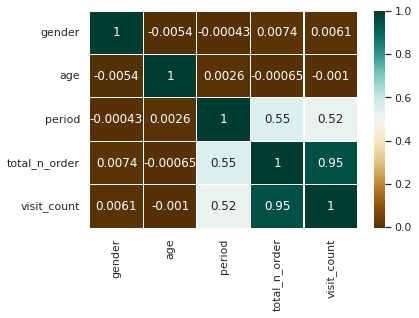

In [ ]:
# 유지기간 짧은 그룹의 상관관계
low_cor = low[['gender','age','period','total_n_order','visit_count']]
sns.heatmap(low_cor.corr(), annot=True, cmap='BrBG', linewidth=0.3)
plt.show();

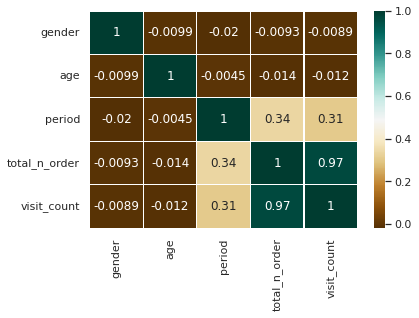

In [ ]:
# 유지기간 긴 그룹의 상관관계
high_cor = high[['gender','age','period','total_n_order','visit_count']]
sns.heatmap(high_cor.corr(), annot=True, cmap='BrBG', linewidth=0.3)
plt.show();

- 유의미한 인사이트를 얻지못함
- 어떤 아이템의 상세페이지를 봤는지 데이터 상으로 확인할 수 없어 생성할 수 있는 지표(특성)가 한정적
- 유지기간-총주문건수, 유지기간-방문일수는 상관관계가 있을 수 밖에 없는 요소
- 유지기간과 인적 특성은 전혀 상관관계가 없음(음수면 음의 상관관계, 양수면 양의 상관관계, 0이면 상관관계 없음)

###4-3-4. 평균 주문 소요시간

In [5]:
fnn = pd.read_csv('./data/fnn.csv')
fnn.rename(columns={'event_name':'step', 'event_date':'date'}, inplace=True)
# fnn = fnn.sort_values(by=['customer_id','date'])
fnn.head()

,customer_id,step,date
0,18770,6,2021-01-01
1,18770,0,2021-01-01
2,18770,0,2021-01-09
3,18770,4,2021-01-09
4,18770,5,2021-01-10


In [6]:
fnn = fnn.groupby(['customer_id','date'], as_index=False).agg({'step':'unique'})
fnn.head()

,customer_id,date,step
0,3,2021-01-09,"[0, 4, 3, 1]"
1,3,2021-01-10,"[6, 0, 2]"
2,3,2021-02-06,"[0, 4]"
3,3,2021-02-07,[6]
4,3,2021-03-02,[0]


In [7]:
fnn['step'] = fnn['step'].apply(lambda x:list(x))

In [10]:
fnn['step'] = fnn['step'].apply(lambda x:process(x))

In [34]:
data = fnn.copy()
data = data.set_index('customer_id')
data.head()

,date,step
customer_id,,
3,2021-01-09,0134
3,2021-01-10,0256
3,2021-02-06,04
3,2021-02-07,56
3,2021-03-02,0


In [35]:
data.index.unique()

Int64Index([    3,     8,     9,    11,    15,    18,    20,    21,    24,
               27,
            ...
            99980, 99985, 99986, 99987, 99988, 99989, 99991, 99992, 99995,
            99998],
           dtype='int64', name='customer_id', length=42432)

In [13]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
idx_count = data.index.value_counts()
idx_count[3]

134

In [37]:
data.loc[3,'step']

customer_id
3    0134
3    0256
3      04
3      56
3       0
     ... 
3       4
3       0
3       4
3       1
3      56
Name: step, Length: 134, dtype: object

In [38]:
from tqdm.notebook import tqdm
idx_count = data.index.value_counts()
data['no'] = 0

for i in tqdm(data.index.unique()):
    num_lst = [ j for j in range(idx_count[i])]
    data.loc[i, 'no'] = num_lst

  0%|          | 0/42432 [00:00<?, ?it/s]

In [21]:
data.head()

,date,step,no,order_num
customer_id,,,,
3,2021-01-09,0134,0,1
3,2021-01-10,0256,1,1
3,2021-02-06,04,2,2
3,2021-02-07,56,3,2
3,2021-03-02,0,4,3


In [39]:
data.tail(20)

,date,step,no
customer_id,,,
99998,2021-07-22,56,12
99998,2021-12-20,0,13
99998,2021-12-21,4,14
99998,2021-12-22,04,15
99998,2021-12-24,14,16
99998,2021-12-25,04,17
99998,2021-12-27,14,18
99998,2021-12-28,04,19
99998,2021-12-29,04,20


In [45]:
df = data.copy()
df['order_num'] = 0
for i in tqdm(df.index.unique()):
    step = list(df.loc[i,'step'])
    num = 1
    num_lst = []

    for j in range(idx_count[i]): #range(len(df.loc[i,:])
        if j==0:
            num_lst.append(num)
        elif j>0:
            if ('5' in step[j-1]) or ('6' in step[j-1]):
                num += 1
                num_lst.append(num)
            else:
                num_lst.append(num)
    
    df.loc[i, 'order_num'] = num_lst

  0%|          | 0/42432 [00:00<?, ?it/s]

In [50]:
df = df.reset_index()
# df.drop('index', axis=1, inplace=True)
df.head()

,customer_id,date,step,no,order_num
0,3,2021-01-09,0134,0,1
1,3,2021-01-10,0256,1,1
2,3,2021-02-06,04,2,2
3,3,2021-02-07,56,3,2
4,3,2021-03-02,0,4,3


In [53]:
start = df.groupby(['customer_id','order_num'], as_index=False)['date'].min()
end = df.groupby(['customer_id','order_num'], as_index=False)['date'].max()

In [60]:
start['date'] = pd.to_datetime(start['date'])
end['date'] = pd.to_datetime(end['date'])

df['diff'] = (end['date'] - start['date']).dt.days
df['diff'].fillna(0, inplace=True)
df.head()

,customer_id,date,step,no,order_num,diff
0,3,2021-01-09,0134,0,1,1.0
1,3,2021-01-10,0256,1,1,1.0
2,3,2021-02-06,04,2,2,5.0
3,3,2021-02-07,56,3,2,12.0
4,3,2021-03-02,0,4,3,14.0


In [93]:
df['diff'] = df['diff'].apply(lambda x:x+1)
df['diff']

0           2.0
1           2.0
2           6.0
3          13.0
4          15.0
           ... 
2238898     1.0
2238899     1.0
2238900     1.0
2238901     1.0
2238902     1.0
Name: diff, Length: 2238903, dtype: float64

In [94]:
# 고객별 평균 주문 소요기간
avg_diff = df.groupby(['customer_id'], as_index=False)['diff'].mean()
avg_diff

,customer_id,diff
0,3,10.507463
1,8,14.181818
2,9,4.605263
3,11,154.000000
4,15,8.826087
...,...,...
42427,99989,1.000000
42428,99991,1.000000
42429,99992,1.000000
42430,99995,1.000000


In [95]:
avg_diff['diff'].describe()

count    42432.000000
mean         2.953483
std          5.805327
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        248.000000
Name: diff, dtype: float64

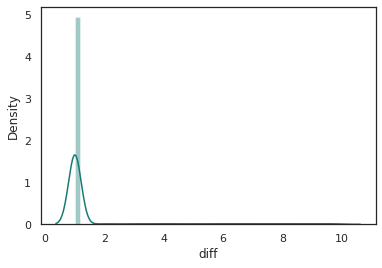

In [96]:
sns.distplot(avg_diff[avg_diff['diff']<10]['diff'])
plt.show();

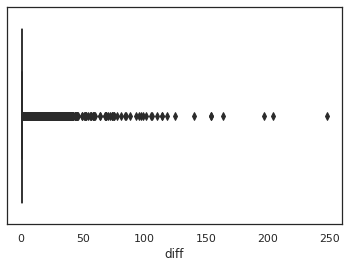

In [97]:
sns.boxplot(data=avg_diff, x='diff')
plt.show();

In [98]:
# 전체 평균 주문 소요기간
avg_diff['diff'].mean()

2.9534833807461887

In [99]:
df.head()

,customer_id,date,step,no,order_num,diff
0,3,2021-01-09,0134,0,1,2.0
1,3,2021-01-10,0256,1,1,2.0
2,3,2021-02-06,04,2,2,6.0
3,3,2021-02-07,56,3,2,13.0
4,3,2021-03-02,0,4,3,15.0


In [100]:
# 퍼널 유형
step_type = pd.DataFrame(df['step'].value_counts().sort_values(ascending=False))
step_type.head(20)

,step
0,839604
56,257202
04,237582
4,129797
01,116201
1,95994
014,52201
02,44206
2,44010
056,36669


In [103]:
df.groupby(['customer_id', 'order_num'])['step'].unique()

customer_id  order_num
3            1                                          [0134, 0256]
             2                                              [04, 56]
             3                                        [0, 14, 4, 56]
             4                                        [0, 4, 23, 56]
             5            [0, 01234, 01, 012, 024, 24, 04, 0124, 56]
                                             ...                    
99995        47                                         [0, 014, 56]
             48                                          [014, 0156]
99998        1                                     [0, 0134, 01, 56]
             2                                   [0, 14, 04, 01, 56]
             3                                 [0, 4, 04, 14, 3, 56]
Name: step, Length: 448965, dtype: object